In [2]:
import torchvision.transforms as transforms 
from torchvision.transforms.functional import InterpolationMode
from PIL import Image
import hiera
from timm.data.constants import IMAGENET_DEFAULT_MEAN, IMAGENET_DEFAULT_STD

In [3]:
from torchvision.io import read_video
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torch, hiera

30.0


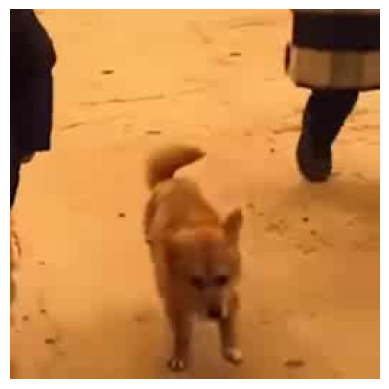

In [4]:
# I used the following command to sample these videos:
#   ffmpeg -i vid.mp4 -vf "crop=w=min(iw\,ih):h=min(iw\,ih),scale=256:256,fps=fps=30" -ss 00:00:00 -t 00:00:05 output.mp4
vid_path = "./dog_30fps.mp4"  # Also try "goat.mp4"!

# Load the frames
frames, audio, info = read_video(vid_path, pts_unit='sec', output_format='THWC')
frames = frames.float() / 255  # Convert from byte to float
print(info['video_fps'])  # Should be 30

plt.figure(frameon=False)
plt.imshow(frames[72].numpy())  # Frame 72 of the video
plt.axis("off")
plt.show()  # compressedboye

In [5]:
# Sample 16 frames with 4 temporal stride: 64 frames per clip, but take every 4th frame
# During testing, we sample 5 clips uniformly in time (and 3 in space) and avg the results
# This is important because videos can be long with an action any point in the video
# Let's just do 2 for demo purposes
frames = torch.stack([frames[:64], frames[64:128]], dim=0)
frames = frames[:, ::4]  # Sample every 4 frames
frames.shape



torch.Size([2, 16, 256, 256, 3])

In [6]:
# Interpolate the frames to 224 and put channels first
frames = frames.permute(0, 4, 1, 2, 3).contiguous()
frames = F.interpolate(frames, size=(16, 224, 224), mode="trilinear")
frames.shape

torch.Size([2, 3, 16, 224, 224])

In [7]:
# Normalize the clip
frames = frames - torch.tensor([0.45, 0.45, 0.45]).view(1, -1, 1, 1, 1)     # Subtract mean
frames = frames / torch.tensor([0.225, 0.225, 0.255]).view(1, -1, 1, 1, 1)  # Divide by std

In [8]:
model = hiera.hiera_base_16x224(pretrained=True, checkpoint="mae_k400_ft_k400")  # Checkpoint is optional (will use default)


In [62]:
# Get kinetics classes as output
out = model(frames)

# Average results over the clips
out = out.mean(0)

# 363: training dog  (kinetics-400)
# 125: feeding goat  (kinetics-400)
out.argmax(dim=-1).item()

378

In [63]:
model = hiera.hiera_base_16x224(pretrained=True, checkpoint="mae_k400")  # Checkpoint is optional (will use default)


In [64]:

mask = model.get_random_mask(frames, 0.2)
out = model(frames, mask=mask)
out_nomask = model(frames)

print(mask.shape)
print(out.shape)
print(out_nomask.shape)
print(frames.shape)


torch.Size([2, 392])
torch.Size([2, 313, 768])
torch.Size([2, 400])
torch.Size([2, 3, 16, 224, 224])


In [9]:
import torch
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML


# Select the video and convert to numpy for processing
video_frames = frames.permute(0, 2, 3, 4, 1)[0].numpy()  # Select the first video

fig, ax = plt.subplots()

def update(i):
    ax.clear()
    ax.imshow(video_frames[i])
    ax.axis('off')

anim = FuncAnimation(fig, update, frames=len(video_frames), interval=100)
plt.close(fig)  # Prevents additional static plot from showing

# Display the animation in the notebook
HTML(anim.to_jshtml())

In [9]:
import hiera 

# model = hiera.hiera_base_16x224(pretrained=True, checkpoint="mae_k400")  # Checkpoint is optional (will use default)
model = hiera.mae_hiera_base_16x224(pretrained=True, checkpoint="mae_k400")



In [11]:
from torchsummary import summary
summary(model.cuda(), input_size=(3, 16, 224, 224))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv3d-1        [-1, 96, 8, 56, 56]          42,432
        PatchEmbed-2            [-1, 25088, 96]               0
            Unroll-3            [-1, 25088, 96]               0
         LayerNorm-4             [-1, 9984, 96]             192
            Linear-5            [-1, 9984, 288]          27,936
            Linear-6             [-1, 9984, 96]           9,312
 MaskUnitAttention-7             [-1, 9984, 96]               0
          Identity-8             [-1, 9984, 96]               0
         LayerNorm-9             [-1, 9984, 96]             192
           Linear-10            [-1, 9984, 384]          37,248
             GELU-11            [-1, 9984, 384]               0
          Dropout-12            [-1, 9984, 384]               0
         Identity-13            [-1, 9984, 384]               0
           Linear-14             [-1, 9

In [1]:

%load_ext autoreload
%autoreload 2

In [4]:
import hiera 
import torch 

# model = hiera.hiera_base_16x224(pretrained=True, checkpoint="mae_k400")  # Checkpoint is optional (will use default)
model = hiera.mae_hiera_base_16x224(pretrained=True, checkpoint="mae_k400")
frames = torch.rand((2, 3, 16, 224, 224))
out = model(frames[0:1,...], mask_ratio=0.99)

# latent, mask = self.forward_encoder(x, mask_ratio, mask=mask)
# pred, pred_mask = self.forward_decoder(
#         latent, mask
#     )  # pred_mask is mask at resolution of *prediction*


# print(frames.shape)
# print(out[1].shape)
# print(out[2].shape)
# print(out[3].shape)


> /private/home/hadyelsahar/anaconda3/envs/videowm/lib/python3.9/site-packages/hiera/hiera_mae.py(273)forward_loss()
    271         import pdb
    272         pdb.set_trace()
--> 273         if len(self.q_stride) == 2:
    274             label = self.get_pixel_label_2d(x, mask)
    275         elif len(self.q_stride) == 3:



In [55]:
import numpy as np 

print(np.prod(frames[0].shape))
print(np.prod(out[0].shape))
print(np.prod(out[1].shape))
print(np.prod(out[2].shape))
print(np.prod(out[3].shape))

2408448
1.0
1195008
1195008
392


In [5]:
frames.shape

torch.Size([2, 3, 16, 224, 224])